In [3]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load dataset
df = pd.read_excel("/content/Peoples_Climate_Vote_Database_2024.xlsx")

In [5]:
df['Country'] = df['Country'].replace({
    'United States of America (the)': 'USA',
    'United Kingdom of Great Britain and Northern Ireland (the)': 'UK',
    'Democratic Republic of the Congo': 'DRC',
    'Iran (Islamic Republic of)': 'Iran',
    'Niger (the)': 'Niger',
    'Philippines (the)': 'Philippines',
    'Tanzania (the United Republic of)': 'Tanzania',
    'Russian Federation (the)': 'Russia',
    'Republic of Korea (the)': 'South Korea'
})


In [6]:
# Quick look at dataset
print(df.shape)
print(df.columns)

(45784, 17)
Index(['Column1', 'ID', 'CID', 'QID', 'RID', 'EID', 'AID', 'Country',
       'Question Text', 'Question Text (Short)', 'Response', 'Education',
       'Age', 'Weighted Mean', 'Cat ID', 'Category', 'Question Context'],
      dtype='object')


In [7]:
#Filter the question given
question_text = "How quickly should your country replace coal, oil, and gas with renewable energy, such as power from the wind or sun?"
df_question = df[df['Question Text'] == question_text]
df_question = df_question[['Country', 'Age', 'Question Text', 'Response', 'Weighted Mean']]
df_question = df_question[~df_question['Age'].isin(['All Ages'])]
df_question = df_question[df_question['Response'] == "Very quickly"]
df_question['Weighted Mean'] = df_question['Weighted Mean'].replace('NA', np.nan)
df_question = df_question.dropna(subset=['Weighted Mean'])
df_question.shape

(147, 5)

In [8]:
#Considering various age groups into Young and Old
age_map = {
    'Under 18': 'Young',
    '18 to 35': 'Young',
    '36 to 59': 'Old',
    '60 plus': 'Old',
    'All Ages': 'All Ages'  # keep aggregate row
}
df_question['Age Group'] = df_question['Age'].map(age_map)
print("Unique Age Groups after mapping:", df_question['Age Group'].unique())



Unique Age Groups after mapping: ['Young' 'Old']


In [9]:
#Choosing only relevant columns
df_clean = df_question[['Country', 'Age Group', 'Weighted Mean']].copy()
df_clean.rename(columns={'Weighted Mean': '% Urgent'}, inplace=True)

In [10]:
#Start with separating Young and Old groups
df_age = df_clean[df_clean['Age Group'].isin(['Young', 'Old'])]

# Pivot table to get % Urgent for Young and Old
pivot = df_age.pivot_table(
    index='Country',
    columns='Age Group',
    values='% Urgent',
    aggfunc=np.mean  # mean across education levels
).reset_index()

# Calculate Age Gap
pivot['Age Gap'] = pivot['Young'] - pivot['Old']
pivot['Absolute Gap'] = pivot['Age Gap'].abs()

# Sort countries by magnitude of absolute age gap
age_gap_master = pivot.sort_values('Absolute Gap', ascending=False)


/tmp/ipython-input-36956848.py:5: FutureWarning: The provided callable <function mean at 0x7829f17a0220> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = df_age.pivot_table(


In [12]:
from os import truncate
#Save outputs of only very quickly responses
df_clean.to_csv("PCV2024_VeryQuickly_CleanDataset.csv", index=False)
age_gap_master.to_csv("PCV2024_AgeGap_MasterTable.csv", index=False)


In [13]:
age_gap_master

Age Group,Country,Old,Young,Age Gap,Absolute Gap
62,USA,23.5,38.0,14.5,14.5
61,UK,32.0,43.0,11.0,11.0
52,Samoa,51.0,41.0,-10.0,10.0
0,Afghanistan,31.0,39.0,8.0,8.0
23,Ghana,61.0,54.0,-7.0,7.0
...,...,...,...,...,...
3,Australia,41.5,42.0,0.5,0.5
29,Indonesia,19.0,19.0,0.0,0.0
18,El Salvador,20.0,20.0,0.0,0.0
32,Italy,46.0,NaN,NaN,NaN


In [14]:
# Group countries by region (Europe, Asia, Africa, Americas, Oceania)
# Differentiating countries into regions

region_map = {
    # Africa
    'South Africa': 'Africa', 'Ghana': 'Africa', 'Nigeria': 'Africa', 'Kenya': 'Africa',
    'Ethiopia': 'Africa', 'Tanzania': 'Africa', 'Uganda': 'Africa',
    'Zimbabwe': 'Africa', 'Sudan': 'Africa', 'Morocco': 'Africa', 'Algeria': 'Africa',
    'Egypt': 'Africa', 'Madagascar': 'Africa', 'Mozambique': 'Africa', 'Benin': 'Africa',
    'Burkina Faso': 'Africa', "Côte d'Ivoire": 'Africa', 'Niger': 'Africa',
    'DRC': 'Africa',

    # Asia & Pacific
    'India': 'Asia-Pacific', 'Bangladesh': 'Asia-Pacific', 'China': 'Asia-Pacific',
    'Indonesia': 'Asia-Pacific', 'Japan': 'Asia-Pacific', 'South Korea': 'Asia-Pacific',
    'Cambodia': 'Asia-Pacific', 'Nepal': 'Asia-Pacific', 'Myanmar': 'Asia-Pacific',
    'Bhutan': 'Asia-Pacific', 'Lao PDR': 'Asia-Pacific', 'Pakistan': 'Asia-Pacific',
    'Philippines': 'Asia-Pacific', 'Sri Lanka': 'Asia-Pacific', 'Australia': 'Asia-Pacific',
    'Papua New Guinea': 'Asia-Pacific', 'Fiji': 'Asia-Pacific', 'Solomon Islands': 'Asia-Pacific',
    'Vanuatu': 'Asia-Pacific', 'Samoa': 'Asia-Pacific', 'Comoros': 'Asia-Pacific',
    'Kyrgyzstan': 'Asia-Pacific',

    # Europe
    'UK': 'Europe', 'France': 'Europe', 'Germany': 'Europe', 'Spain': 'Europe', 'Italy': 'Europe',
    'Romania': 'Europe', 'Greece': 'Europe', 'Czechia': 'Europe', 'Russia': 'Europe',

    # Americas
    'USA': 'Americas', 'Canada': 'Americas',
    'Mexico': 'Americas', 'Brazil': 'Americas', 'Argentina': 'Americas',
    'Colombia': 'Americas', 'Peru': 'Americas', 'Ecuador': 'Americas',
    'Dominican Republic': 'Americas', 'Paraguay': 'Americas',
    'Guatemala': 'Americas', 'Honduras': 'Americas', 'Nicaragua': 'Americas',
    'Haiti': 'Americas', 'El Salvador': 'Americas', 'Barbados': 'Americas',

    # Middle East & North Africa (MENA)
    'Saudi Arabia': 'MENA', 'Iran': 'MENA', 'Iraq': 'MENA',
    'Jordan': 'MENA', 'Tunisia': 'MENA', 'Morocco': 'MENA', 'Sudan': 'MENA',
    'Afghanistan': 'MENA', 'Egypt': 'MENA',

    # fallback
    'Global': 'Global'
}

age_gap_master['Region'] = age_gap_master['Country'].map(region_map)


In [16]:
#Descriptive Statistics
stats = age_gap_master['Absolute Gap'].describe(percentiles=[0.25, 0.5, 0.75]).to_frame().T
stats['range'] = stats['max'] - stats['min']
stats['std'] = age_gap_master['Age Gap'].std()
print("Descriptive Statistics for Age Gap")
print(stats.T)

Descriptive Statistics for Age Gap
       Absolute Gap
count     63.000000
mean       3.984127
std        4.875761
min        0.000000
25%        2.000000
50%        3.000000
75%        6.000000
max       14.500000
range     14.500000


In [18]:
#Identify Countries with Largest and Smallest Gaps
ranked = age_gap_master

top5_largest_gaps = age_gap_master.sort_values('Absolute Gap', ascending=False).head(5)
top5_smallest_gaps = age_gap_master.sort_values('Absolute Gap', ascending=True).head(5)
#reversals = age_gap_master[age_gap_master['Age Gap'] < 0].sort_values('Age Gap')

print("\n Top 5 largest gaps")
print(top5_largest_gaps)

print("\n Top 5 smallest gaps")
print(top5_smallest_gaps)


 Top 5 largest gaps
Age Group      Country   Old  Young  Age Gap  Absolute Gap        Region
62                 USA  23.5   38.0     14.5          14.5      Americas
61                  UK  32.0   43.0     11.0          11.0        Europe
52               Samoa  51.0   41.0    -10.0          10.0  Asia-Pacific
0          Afghanistan  31.0   39.0      8.0           8.0          MENA
23               Ghana  61.0   54.0     -7.0           7.0        Africa

 Top 5 smallest gaps
Age Group      Country   Old  Young  Age Gap  Absolute Gap        Region
29           Indonesia  19.0   19.0      0.0           0.0  Asia-Pacific
18         El Salvador  20.0   20.0      0.0           0.0      Americas
3            Australia  41.5   42.0      0.5           0.5  Asia-Pacific
47            Paraguay  30.0   29.0     -1.0           1.0      Americas
25           Guatemala  21.0   22.0      1.0           1.0      Americas


1. The largest positive gaps are mostly in developed or industrialized countries (USA, UK).

2. The largest negative gaps appear in some African countries and small island states (Samoa), suggesting older populations sometimes express higher urgency, possibly due to climate vulnerability.

3. Developing countries and Least Developed Countries (like Bangladesh, Benin, Democratic Republic of Congo, Ethiopia, Nepal, Madagascar) show smaller gaps (1-2), indicating more consensus across age groups.

4. Overall trend: Youth generally push for more urgent renewable transition, strongest in industrialized regions.




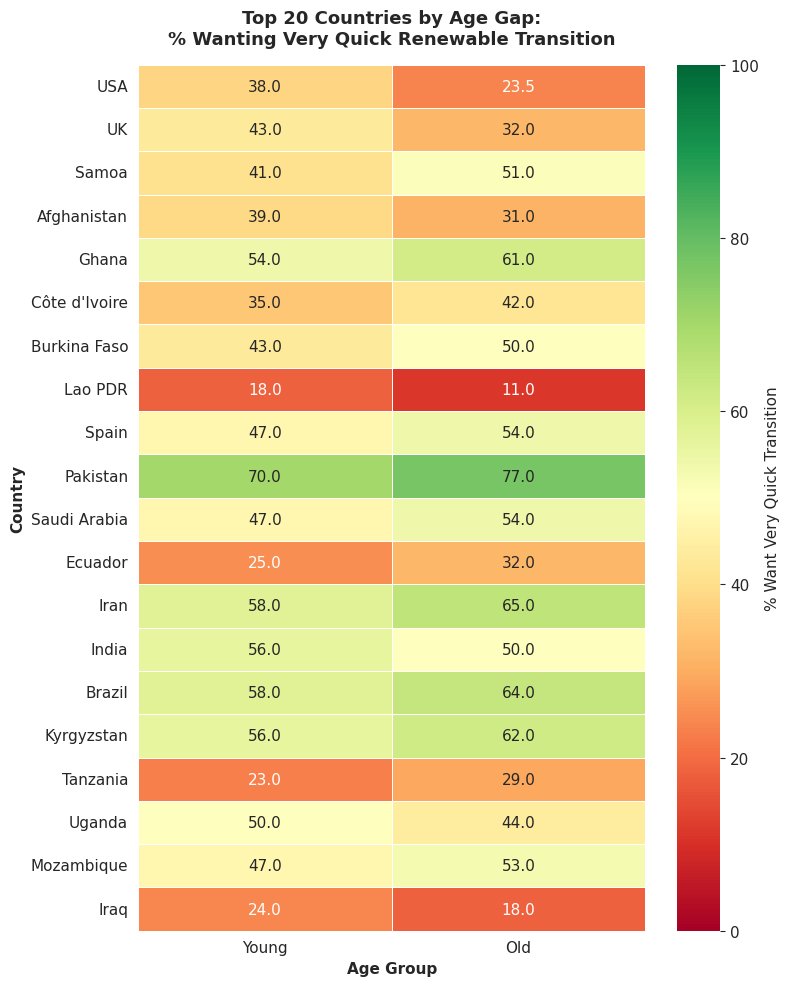

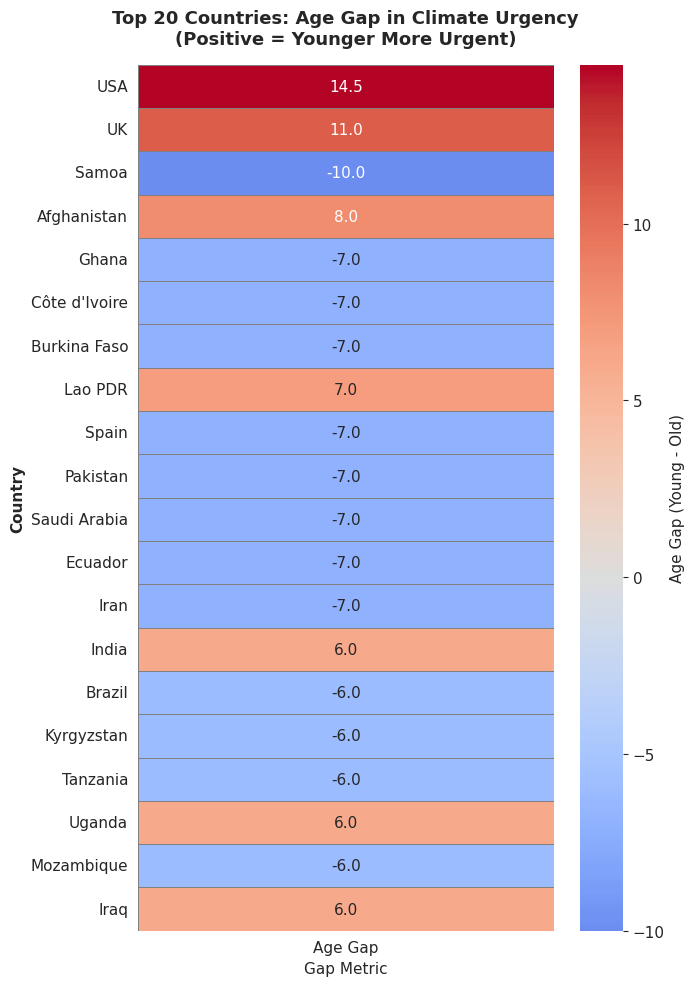

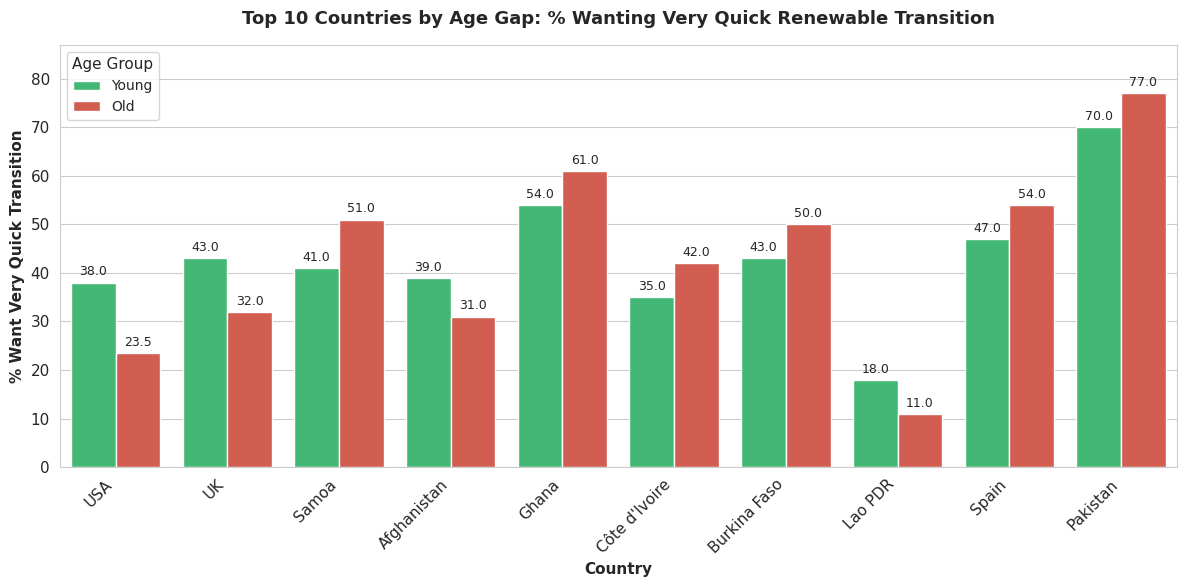

/tmp/ipython-input-2264088126.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


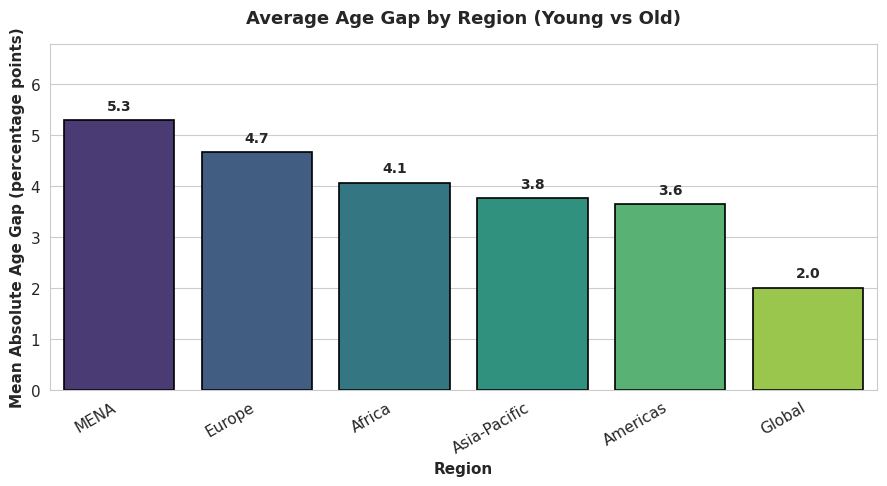

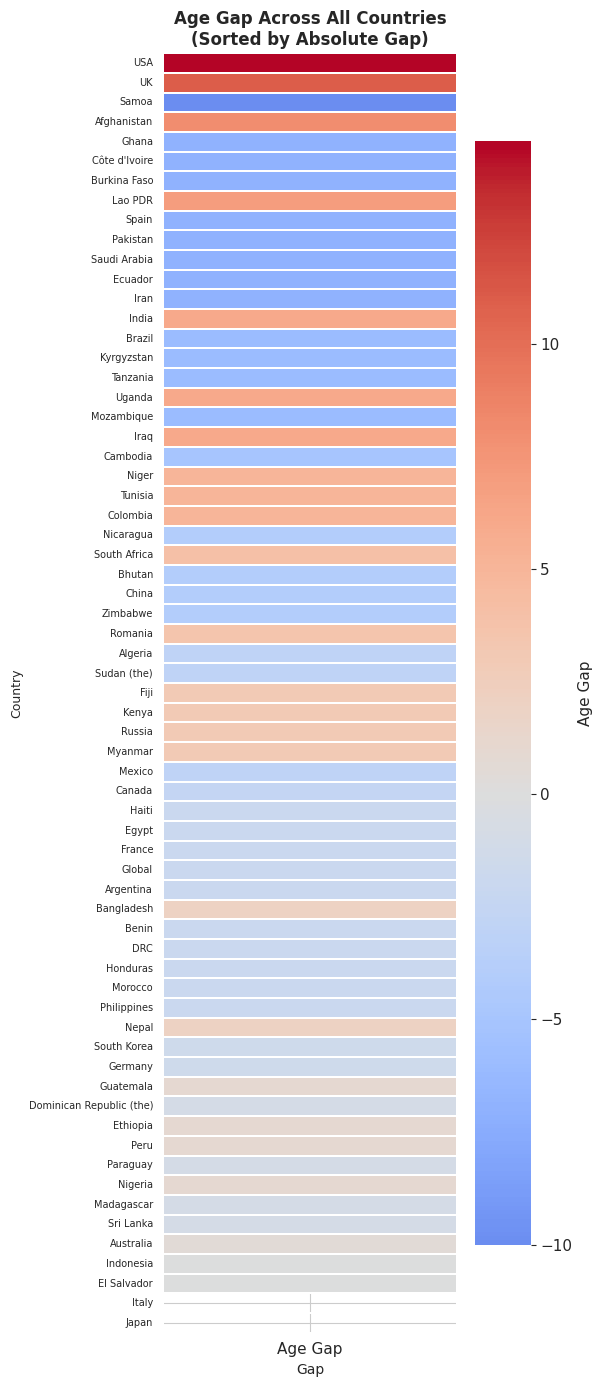


 All visualizations saved to 'outputs/' folder


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create outputs folder
os.makedirs('outputs', exist_ok=True)

#style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11
#HEATMAP: Top 20 Countries - Young vs Old
top20 = age_gap_master.sort_values('Absolute Gap', ascending=False).head(20)

#Prepare data for heatmap
heat_data = top20.set_index('Country')[['Young', 'Old']]

plt.figure(figsize=(8, 10))
sns.heatmap(
    heat_data,
    annot=True,           # Show values
    fmt='.1f',            # 1 decimal place
    cmap='RdYlGn',        # Red-Yellow-Green
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': '% Want Very Quick Transition'},
    vmin=0, vmax=100      # Percentage scale
)
plt.title('Top 20 Countries by Age Gap:\n% Wanting Very Quick Renewable Transition',
          fontsize=13, fontweight='bold', pad=15)
plt.xlabel('Age Group', fontsize=11, fontweight='bold')
plt.ylabel('Country', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/heatmap_top20_young_vs_old.png', dpi=300, bbox_inches='tight')
plt.show()

#HEATMAP: Age Gap
top20_gap = top20.set_index('Country')[['Age Gap']]

plt.figure(figsize=(7, 10))
sns.heatmap(
    top20_gap,
    annot=True,
    fmt='.1f',
    cmap='coolwarm',      # Diverging: blue (negative) to red (positive)
    center=0,             # White at zero
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Age Gap (Young - Old)'}
)
plt.title('Top 20 Countries: Age Gap in Climate Urgency\n(Positive = Younger More Urgent)',
          fontsize=13, fontweight='bold', pad=15)
plt.xlabel('Gap Metric', fontsize=11)
plt.ylabel('Country', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/heatmap_age_gap_top20.png', dpi=300, bbox_inches='tight')
plt.show()

#GROUPED BAR CHART: Top 10 Countries
top10 = age_gap_master.sort_values('Absolute Gap', ascending=False).head(10)

#Melt properly
top10_melted = top10.melt(
    id_vars='Country',
    value_vars=['Young', 'Old'],
    var_name='Age Group',
    value_name='% Very Quick'  #Fixed variable name
)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top10_melted,
    x='Country',
    y='% Very Quick',
    hue='Age Group',
    palette={'Young': '#2ecc71', 'Old': '#e74c3c'}  #Green for Young, red for Old
)

#Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3, fontsize=9)

plt.title('Top 10 Countries by Age Gap: % Wanting Very Quick Renewable Transition',
          fontsize=13, fontweight='bold', pad=15)
plt.xlabel('Country', fontsize=11, fontweight='bold')
plt.ylabel('% Want Very Quick Transition', fontsize=11, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Age Group', fontsize=10, title_fontsize=11)
plt.ylim(0, max(top10_melted['% Very Quick']) + 10)  # Add headroom for labels
plt.tight_layout()
plt.savefig('outputs/grouped_bar_top10_age_gap.png', dpi=300, bbox_inches='tight')
plt.show()

#REGIONAL COMPARISON (Bar Chart)
region_avg = (
    age_gap_master.groupby('Region', dropna=False)['Absolute Gap']
    .mean()
    .reset_index()
    .sort_values('Absolute Gap', ascending=False)
)

plt.figure(figsize=(9, 5))
ax = sns.barplot(
    data=region_avg,
    x='Region',
    y='Absolute Gap',
    palette='viridis',
    edgecolor='black',
    linewidth=1.2
)

# Add value labels
for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.2,
        f'{bar.get_height():.1f}',
        ha='center', fontsize=10, fontweight='bold'
    )

plt.title('Average Age Gap by Region (Young vs Old)',
          fontsize=13, fontweight='bold', pad=15)
plt.xlabel('Region', fontsize=11, fontweight='bold')
plt.ylabel('Mean Absolute Age Gap (percentage points)', fontsize=11, fontweight='bold')
plt.xticks(rotation=30, ha='right')
plt.ylim(0, region_avg['Absolute Gap'].max() + 1.5)
plt.tight_layout()
plt.savefig('outputs/bar_region_age_gap.png', dpi=300, bbox_inches='tight')
plt.show()

#Summary Heatmap for all countries
all_gap = age_gap_master.sort_values('Absolute Gap', ascending=False).set_index('Country')[['Age Gap']]

plt.figure(figsize=(6, 14))
sns.heatmap(
    all_gap,
    annot=False,          # No labels (too many countries)
    cmap='coolwarm',
    center=0,
    linewidths=0.1,
    cbar_kws={'label': 'Age Gap'}
)
plt.title('Age Gap Across All Countries\n(Sorted by Absolute Gap)',
          fontsize=12, fontweight='bold')
plt.xlabel('Gap', fontsize=10)
plt.ylabel('Country', fontsize=9)
plt.yticks(fontsize=7)  # Smaller country labels
plt.tight_layout()
plt.savefig('outputs/heatmap_all_countries_compact.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n All visualizations saved to 'outputs/' folder")